In [59]:
import sys
import getpass
import os
import pandas as pd
import fiona
import geopandas as gpd
from arcgis import gis
username = getpass.getuser()

user = getpass.getuser()
sys.dont_write_bytecode = True

# for DataViz team members
sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [5]:
transit_dir = os.path.join('/Users',
                        username,
                        'Box',
                        'DataViz Projects',
                        'Spatial Analysis and Mapping',
                        'Active Transportation Plan',
                        'Data',
                        'regional_transit')

In [7]:
client = gis.GIS(url='https://arcgis.ad.mtc.ca.gov/portal/',username=username,verify_cert=False)

Enter password: ········


## Pull transit data from BAM portal

In [60]:
transit_rts = pull_geodata_from_argis(arcgis_data_id='2a519083d0a44a33940e469e427c8457',
                                      client=client)

In [61]:
transit_rts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5931 entries, 0 to 5930
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   SHAPE__Length  5931 non-null   float64 
 1   agency_id      5931 non-null   object  
 2   agency_nm      5931 non-null   object  
 3   objectid       5931 non-null   int64   
 4   route_id       5931 non-null   object  
 5   route_l_nm     5931 non-null   object  
 6   route_s_nm     5931 non-null   object  
 7   route_type     5931 non-null   object  
 8   geom           5931 non-null   geometry
dtypes: float64(1), geometry(1), int64(1), object(6)
memory usage: 417.1+ KB


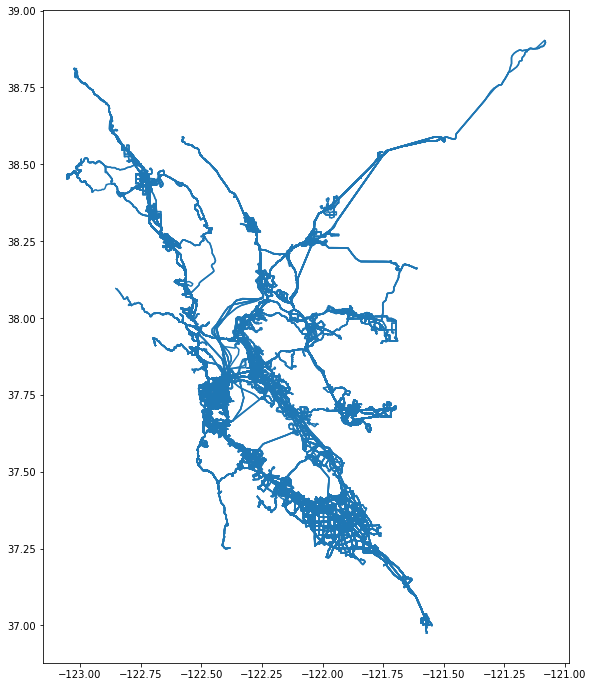

In [62]:
transit_rts.plot(figsize=(12,12));

## Read transit routes classification xlsx

In [63]:
os.listdir(transit_dir)

['BA_Agency_Category_0821.xlsx']

In [64]:
transit_class = pd.read_excel(os.path.join(transit_dir,'BA_Agency_Category_0821.xlsx'),
                              sheet_name=2)

In [65]:
transit_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                798 non-null    object
 1   agency_id               798 non-null    object
 2   agency                  798 non-null    object
 3   route_short_name        796 non-null    object
 4   route_long_name         764 non-null    object
 5   category                740 non-null    object
 6   sub_category            718 non-null    object
 7   avg_peak_freq (min)     608 non-null    object
 8   avg_offpeak_freq (min)  410 non-null    object
 9   notes/comments          238 non-null    object
dtypes: object(10)
memory usage: 62.5+ KB


In [66]:
#Fix BART route ids to match shape ids
ba_dict = {'BA:BG-N': 'BA:Beige',
 'BA:BG-S': 'BA:Beige',
 'BA:BL-N': 'BA:Blue-Wkd/Sat',
 'BA:BL-S': 'BA:Blue-Wkd/Sat',
 'BA:GN-N': 'BA:Green',
 'BA:GN-S': 'BA:Green',
 'BA:OR-N': 'BA:Orange',
 'BA:OR-S': 'BA:Orange',
 'BA:PR-N': 'BA:Purple',
 'BA:PR-S': 'BA:Purple',
 'BA:RD-N': 'BA:Red',
 'BA:RD-S': 'BA:Red',
 'BA:YL-N': 'BA:Yellow',
 'BA:YL-S': 'BA:Yellow'}

transit_class['route_id'].replace(ba_dict,inplace=True)

In [67]:
transit_rts_class = pd.merge(transit_rts[['route_id','geom']],
                             transit_class,how='outer',
                             on='route_id',
                             indicator=True)

## Write non-match files to csv

In [72]:
transit_rts_class[transit_rts_class['_merge'] == 'right_only']['agency_id'].unique()

array(['CE', 'CT', 'CC', 'SM', 'SF', 'VN', 'SC'], dtype=object)

In [79]:
class_out_cols = ['agency_id',
                  'agency',
                  'route_short_name',
                  'route_long_name',
                  'category',
                  'sub_category',
                  'avg_peak_freq (min)',
                  'avg_offpeak_freq (min)',
                  'notes/comments']
class_export_df = transit_rts_class[class_out_cols][transit_rts_class['_merge'] == 'right_only'].copy()

In [80]:
agency_ids = ['CE', 'CT', 'CC', 'SM', 'SF', 'VN', 'SC']
shape_out_cols = ['agency_id',
                  'agency_nm',
                  'route_id',
                  'route_l_nm',
                  'route_s_nm',
                  'route_type']
shape_export_df = transit_rts[shape_out_cols][transit_rts['agency_id'].isin(agency_ids)].copy()

In [81]:
with pd.ExcelWriter(os.path.join(transit_dir,'nonmatching_route_ids.xlsx')) as writer:
    class_export_df.to_excel(writer, sheet_name='Unmatched_Route_Ids',index=False)
    shape_export_df.to_excel(writer, sheet_name='Potential_Route_Id_Matches',index=False)